## **<단계 구상>**

**전체 flow**

1) 학습 -> 2) 인증 -> 3) 탐지 -> 4) 대응


**세부 내용**

1) 학습
*   모델 학습
*   사전 학습 후 모델로 저장


2) 인증
*   행 1개 추출, 입력된 데이터의 user ID 확인
*   메모리 버퍼 구현


3) 탐지
*   데이터를 사전 학습된 모델에 넣어서 성능 확인


4) 대응
*   공격자면 패킷 drop하고, 처리율에 반영X
*   인증 테이블에 공격자 기록
*   공격자 인증 취소


In [1]:
!pip install keras

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Activation
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MSE
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import ReduceLROnPlateau
import keras


class ForecastLSTM:
    def __init__(self, random_seed: int = 1234):
        self.random_seed = random_seed

### 1. 종래모델 학습

In [3]:
def reshape_dataset(self, df: pd.DataFrame) -> np.array:
    # y 컬럼을 데이터프레임의 맨 마지막 위치로 이동
    if "y" in df.columns:
        df = df.drop(columns=["y"]).assign(y=df["y"])
    else:
        raise KeyError("Not found target column 'y' in dataset.")
    
    # shape 변경
    dataset = df.values.reshape(df.shape)
    return dataset

ForecastLSTM.reshape_dataset = reshape_dataset

In [4]:
def split_sequences(
    self, dataset: np.array, seq_len: int, steps: int, single_output: bool
) -> tuple:

    # feature와 y 각각 sequential dataset을 반환할 리스트 생성
    X, y = list(), list()
    # sequence length와 step에 따라 sequential dataset 생성
    for i, _ in enumerate(dataset):
        idx_in = i + seq_len
        idx_out = idx_in + steps
        if idx_out > len(dataset):
            break
        seq_x = dataset[i:idx_in, :-1]
        if single_output:
            seq_y = dataset[idx_out - 1 : idx_out, -1]
        else:
            seq_y = dataset[idx_in:idx_out, -1]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)


ForecastLSTM.split_sequences = split_sequences

In [5]:
def split_train_valid_dataset(
    self,
    df: pd.DataFrame,
    seq_len: int,
    steps: int,
    single_output: bool,
    validation_split: float = 0.3,
    verbose: bool = True,
) -> tuple:
    # dataframe을 numpy array로 reshape
    dataset = self.reshape_dataset(df=df)

    # feature와 y를 sequential dataset으로 분리
    X, y = self.split_sequences(
        dataset=dataset,
        seq_len=seq_len,
        steps=steps,
        single_output=single_output,
    )

    # X, y에서 validation dataset 분리
    dataset_size = len(X)
    train_size = int(dataset_size * (1 - validation_split))
    X_train, y_train = X[:train_size, :], y[:train_size, :]
    X_val, y_val = X[train_size:, :], y[train_size:, :]
    if verbose:
        print(f" >>> X_train: {X_train.shape}")
        print(f" >>> y_train: {y_train.shape}")
        print(f" >>> X_val: {X_val.shape}")
        print(f" >>> y_val: {y_val.shape}")
    return X_train, y_train, X_val, y_val


ForecastLSTM.split_train_valid_dataset = split_train_valid_dataset

In [6]:
def build_and_compile_lstm_model(
    self,
    seq_len: int,
    n_features: int,
    lstm_units: list,
    learning_rate: float,
    dropout: float,
    steps: int,
    metrics: str,
    single_output: bool,
    last_lstm_return_sequences: bool = False,
    dense_units: list = None,
    activation: str = None,
):
    """
    LSTM 네트워크를 생성한 결과를 반환한다.

    :param seq_len: Length of sequences. (Look back window size)
    :param n_features: Number of features. It requires for model input shape.
    :param lstm_units: Number of cells each LSTM layers.
    :param learning_rate: Learning rate.
    :param dropout: Dropout rate.
    :param steps: Length to predict.
    :param metrics: Model loss function metric.
    :param single_output: Whether 'yhat' is a multiple value or a single value.
    :param last_lstm_return_sequences: Last LSTM's `return_sequences`. Allow when `single_output=False` only.
    :param dense_units: Number of cells each Dense layers. It adds after LSTM layers.
    :param activation: Activation function of Layers.
    """
    tf.random.set_seed(self.random_seed)
    model = Sequential()

    if len(lstm_units) > 1:
        # LSTM -> ... -> LSTM -> Dense(steps)
        model.add(
            LSTM(
                units=lstm_units[0],
                activation=activation,
                return_sequences=True,
                input_shape=(seq_len, n_features),
            )
        )
        lstm_layers = lstm_units[1:]
        for i, n_units in enumerate(lstm_layers, start=1):
            if i == len(lstm_layers):
                if single_output:
                    return_sequences = False
                else:
                    return_sequences = last_lstm_return_sequences
                model.add(
                    LSTM(
                        units=n_units,
                        activation=activation,
                        return_sequences=return_sequences,
                    )
                )
            else:
                model.add(
                    LSTM(
                        units=n_units,
                        activation=activation,
                        return_sequences=True,
                    )
                )
    else:
        # LSTM -> Dense(steps)
        if single_output:
            return_sequences = False
        else:
            return_sequences = last_lstm_return_sequences
        model.add(
            LSTM(
                units=lstm_units[0],
                activation=activation,
                return_sequences=return_sequences,
                input_shape=(seq_len, n_features),
            )
        )

    if single_output:  # Single Step, Direct Multi Step
        if dense_units:
            for n_units in dense_units:
                model.add(Dense(units=n_units, activation=activation))
        if dropout > 0:
            model.add(Dropout(rate=dropout))
        model.add(Dense(1))
    else:  # Multiple Output Step
        if last_lstm_return_sequences:
            model.add(Flatten())
        if dense_units:
            for n_units in dense_units:
                model.add(Dense(units=n_units, activation=activation))
        if dropout > 0:
            model.add(Dropout(rate=dropout))
        model.add(Dense(units=steps))

    # Compile the model
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss=MSE, metrics=metrics)
    return model


ForecastLSTM.build_and_compile_lstm_model = build_and_compile_lstm_model

In [7]:
def fit_lstm(
    self,
    df: pd.DataFrame,
    steps: int,
    lstm_units: list,
    activation: str,
    dropout: float = 0,
    seq_len: int = 16,
    single_output: bool = False,
    epochs: int = 200,
    batch_size: int = None,
    steps_per_epoch: int = None,
    learning_rate: float = 0.001,
    patience: int = 10,
    validation_split: float = 0.3,
    last_lstm_return_sequences: bool = False,
    dense_units: list = None,
    metrics: str = "acc",
    check_point_path: str = None,
    verbose: bool = False,
    plot: bool = True,
):
    """
    LSTM 기반 모델 훈련을 진행한다.

    :param df: DataFrame for model train.
    :param steps: Length to predict.
    :param lstm_units: LSTM, Dense Layers
    :param activation: Activation function for LSTM, Dense Layers.
    :param dropout: Dropout ratio between Layers.
    :param seq_len: Length of sequences. (Look back window size)
    :param single_output: Select whether 'y' is a continuous value or a single value.
    """

    np.random.seed(self.random_seed)
    tf.random.set_seed(self.random_seed)

    # 훈련, 검증 데이터셋 생성
    (
        self.X_train,
        self.y_train,
        self.X_val,
        self.y_val,
    ) = self.split_train_valid_dataset(
        df=df,
        seq_len=seq_len,
        steps=steps,
        validation_split=validation_split,
        single_output=single_output,
        verbose=verbose,
    )

    # LSTM 모델 생성
    n_features = df.shape[1] - 1
    self.model = self.build_and_compile_lstm_model(
        seq_len=seq_len,
        n_features=n_features,
        lstm_units=lstm_units,
        activation=activation,
        learning_rate=learning_rate,
        dropout=dropout,
        steps=steps,
        last_lstm_return_sequences=last_lstm_return_sequences,
        dense_units=dense_units,
        metrics=metrics,
        single_output=single_output,
    )

    # 모델 적합 과정에서 best model 저장
    if check_point_path is not None:
        # create checkpoint
        checkpoint_path = f"checkpoint/lstm_{check_point_path}.h5"
        checkpoint = ModelCheckpoint(
            filepath=checkpoint_path,
            save_weights_only=False,
            save_best_only=True,
            monitor="val_loss",
            verbose=verbose,
        )
        rlr = ReduceLROnPlateau(
            monitor="val_loss", factor=0.5, patience=patience, verbose=verbose
        )
        callbacks = [checkpoint, EarlyStopping(patience=patience), rlr]
    else:
        rlr = ReduceLROnPlateau(
            monitor="val_loss", factor=0.5, patience=patience, verbose=verbose
        )
        callbacks = [EarlyStopping(patience=patience), rlr]

    # 모델 훈련
    self.history = self.model.fit(
        self.X_train,
        self.y_train,
        batch_size=batch_size,
        steps_per_epoch=steps_per_epoch,
        validation_data=(self.X_val, self.y_val),
        epochs=epochs,
        use_multiprocessing=True,
        workers=8,
        verbose=verbose,
        callbacks=callbacks,
        shuffle=False,
    )

    # 훈련 종료 후 best model 로드
    if check_point_path is not None:
        self.model.load_weights(f"checkpoint/lstm_{check_point_path}.h5")

    # 모델링 과정 시각화
    if plot:
        plt.figure(figsize=(12, 6))
        plt.plot(self.history.history[f"{metrics}"])
        plt.plot(self.history.history[f"val_{metrics}"])
        plt.title("Performance Metric")
        plt.xlabel("Epoch")
        plt.ylabel(f"{metrics}")
        if metrics == "mape":
            plt.axhline(y=10, xmin=0, xmax=1, color="grey", ls="--", alpha=0.5)
        plt.legend(["Train", "Validation"], loc="upper right")
        plt.show()


ForecastLSTM.fit_lstm = fit_lstm

In [8]:
def forecast_validation_dataset(self) -> pd.DataFrame:
    # 검증 데이터셋의 실제 값(y)과, 예측 값(yhat)을 저장할 리스트 생성
    y_pred_list, y_val_list = list(), list()
    
    # 훈련된 모델로 validation dataset에 대한 예측값 생성
    for x_val, y_val in zip(self.X_val, self.y_val):
        x_val = np.expand_dims(
            x_val, axis=0
        )  # (seq_len, n_features) -> (1, seq_len, n_features)
        y_pred = self.model.predict(x_val)[0]
        y_pred_list.extend(y_pred.tolist())
        y_val_list.extend(y_val.tolist())
    return pd.DataFrame({"y": y_val_list, "yhat": y_pred_list})


ForecastLSTM.forecast_validation_dataset = forecast_validation_dataset

In [9]:
def calculate_metrics(df_fcst: pd.DataFrame) -> dict:
    true = df_fcst["y"]
    pred = df_fcst["yhat"]

    mae = (true - pred).abs().mean()
    mape = (true - pred).abs().div(true).mean() * 100
    mse = ((true - pred) ** 2).mean()
    

    l=len(pred)
    score = sum([np.round(pred[i])==true[i] for i in range(l)])/l
    accuracy = score*100
    
    return {
        "mae": mae,
        "mape": mape,
        "mse": mse,
        "acc": accuracy,
    }

In [10]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [11]:
df=pd.read_csv('/content/drive/MyDrive/Dataset/(block) ton_memory.csv')
df

,ts,PID,MINFLT,MAJFLT,VSTEXT,VSIZE,RSIZE,VGROW,RGROW,MEM,CMD,label,type
0,1554218915,3257,859502,54,193,2.0,519.1,2.0,519.1,0.14,Web-Content,0,normal
1,1554218920,3197,247354,95,193,2.6,402.0,2.6,402.0,0.11,firefox,0,normal
2,1554218925,1442,57311,33,2219,764.2,290.7,764.2,290.7,0.08,Xorg,0,normal
3,1554218930,3119,68006,17,3063,725.9,116.8,725.9,116.8,0.03,update-manager,0,normal
4,1554218935,2797,72300,69,1350,1.4,109.6,1.4,109.6,0.03,nautilus,0,normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,1556219648,3293,1912,0,148,17624.0,2372.0,0.0,0.0,0.00,atop,1,dos
9996,1556219653,2499,0,0,415,40184.0,2288.0,0.0,0.0,0.00,dbus-daemon,1,dos
9997,1556219658,1401,3,0,36,19296.0,824.0,0.0,0.0,0.00,irqbalance,1,dos
9998,1556219663,2576,0,0,121,22308.0,640.0,0.0,0.0,0.00,upstart-dbus-b,1,dos


In [12]:
#drop string
df = df.drop(['CMD','type'], axis=1)
df

,ts,PID,MINFLT,MAJFLT,VSTEXT,VSIZE,RSIZE,VGROW,RGROW,MEM,label
0,1554218915,3257,859502,54,193,2.0,519.1,2.0,519.1,0.14,0
1,1554218920,3197,247354,95,193,2.6,402.0,2.6,402.0,0.11,0
2,1554218925,1442,57311,33,2219,764.2,290.7,764.2,290.7,0.08,0
3,1554218930,3119,68006,17,3063,725.9,116.8,725.9,116.8,0.03,0
4,1554218935,2797,72300,69,1350,1.4,109.6,1.4,109.6,0.03,0
...,...,...,...,...,...,...,...,...,...,...,...
9995,1556219648,3293,1912,0,148,17624.0,2372.0,0.0,0.0,0.00,1
9996,1556219653,2499,0,0,415,40184.0,2288.0,0.0,0.0,0.00,1
9997,1556219658,1401,3,0,36,19296.0,824.0,0.0,0.0,0.00,1
9998,1556219663,2576,0,0,121,22308.0,640.0,0.0,0.0,0.00,1


In [13]:
#위 함수에서 라벨을 'y'로 설정해줬기 때문에, 데이터 셋에서 'label'을 'y'로 바꿔줌
df.rename(columns={'label':'y'}, inplace=True)
df

,ts,PID,MINFLT,MAJFLT,VSTEXT,VSIZE,RSIZE,VGROW,RGROW,MEM,y
0,1554218915,3257,859502,54,193,2.0,519.1,2.0,519.1,0.14,0
1,1554218920,3197,247354,95,193,2.6,402.0,2.6,402.0,0.11,0
2,1554218925,1442,57311,33,2219,764.2,290.7,764.2,290.7,0.08,0
3,1554218930,3119,68006,17,3063,725.9,116.8,725.9,116.8,0.03,0
4,1554218935,2797,72300,69,1350,1.4,109.6,1.4,109.6,0.03,0
...,...,...,...,...,...,...,...,...,...,...,...
9995,1556219648,3293,1912,0,148,17624.0,2372.0,0.0,0.0,0.00,1
9996,1556219653,2499,0,0,415,40184.0,2288.0,0.0,0.0,0.00,1
9997,1556219658,1401,3,0,36,19296.0,824.0,0.0,0.0,0.00,1
9998,1556219663,2576,0,0,121,22308.0,640.0,0.0,0.0,0.00,1


In [14]:
df.iloc[7000:7001,:1]

,ts
7000,1556209263


In [15]:
cutoff = 1556209263

In [16]:
df = df.set_index('ts')
df

,PID,MINFLT,MAJFLT,VSTEXT,VSIZE,RSIZE,VGROW,RGROW,MEM,y
ts,,,,,,,,,,
1554218915,3257,859502,54,193,2.0,519.1,2.0,519.1,0.14,0
1554218920,3197,247354,95,193,2.6,402.0,2.6,402.0,0.11,0
1554218925,1442,57311,33,2219,764.2,290.7,764.2,290.7,0.08,0
1554218930,3119,68006,17,3063,725.9,116.8,725.9,116.8,0.03,0
1554218935,2797,72300,69,1350,1.4,109.6,1.4,109.6,0.03,0
...,...,...,...,...,...,...,...,...,...,...
1556219648,3293,1912,0,148,17624.0,2372.0,0.0,0.0,0.00,1
1556219653,2499,0,0,415,40184.0,2288.0,0.0,0.0,0.00,1
1556219658,1401,3,0,36,19296.0,824.0,0.0,0.0,0.00,1


In [17]:
## 1) Train, Test 데이터 분리
df_train = df[df.index < cutoff]
df_test = df[df.index >= cutoff]

In [18]:
## 2) Sequence Length, 예측 기간(Step), Single Output 여부 등 정의


seq_len = 1  # 제안 모델 10, 종래 모델 1
steps = 1  # 향후 5개의 y를 예측
single_output = False  # 향후 5개의 시점만이 아닌, 1~5개 모두 예측


metrics = "acc"  # 모델 성능 지표

In [19]:
## 3) LSTM 하이퍼파라미터 정의
lstm_params = {
    "seq_len": seq_len,
    "epochs": 300,  # epochs 반복 횟수
    "patience": 30,  # early stopping 조건
    "steps_per_epoch": 5,  # 1 epochs 시 dataset을 5개로 분할하여 학습
    "learning_rate": 0.01,
    "lstm_units": [64, 32],  # Dense Layer: 2, Unit: (64, 32)
    "activation": "relu",
    "dropout": 0,
    "validation_split": 0.3,  # 검증 데이터셋 30%
}

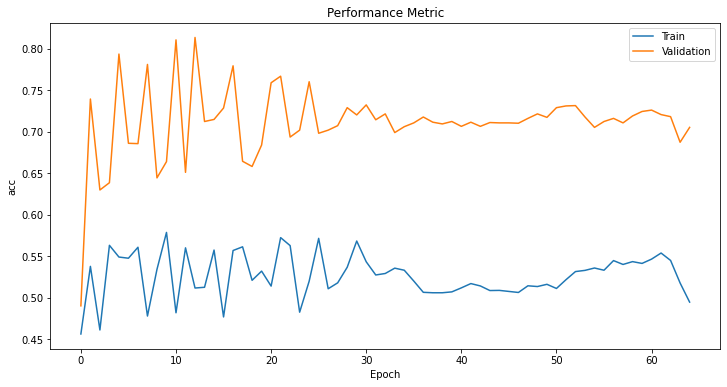

In [20]:
## 4) 모델 훈련
fl = ForecastLSTM()
fl.fit_lstm(
    df=df_train,
    steps=steps,
    single_output=single_output,
    metrics=metrics,
    **lstm_params,
)

In [21]:
## 5) Validation dataset 예측 성능
df_fcst_val = fl.forecast_validation_dataset()

1/1 [==============================] - 0s 19ms/step


In [22]:
val_loss = calculate_metrics(df_fcst=df_fcst_val)[metrics]
print(f"{metrics} of validation dataset: {val_loss.round(3)}")

acc of validation dataset: 61.958


In [23]:
conventional = val_loss

### 2. 제안모델 학습

In [24]:
def reshape_dataset(self, df: pd.DataFrame) -> np.array:
    # y 컬럼을 데이터프레임의 맨 마지막 위치로 이동
    if "y" in df.columns:
        df = df.drop(columns=["y"]).assign(y=df["y"])
    else:
        raise KeyError("Not found target column 'y' in dataset.")
    
    # shape 변경
    dataset = df.values.reshape(df.shape)
    return dataset

ForecastLSTM.reshape_dataset = reshape_dataset

In [25]:
def split_sequences(
    self, dataset: np.array, seq_len: int, steps: int, single_output: bool
) -> tuple:

    # feature와 y 각각 sequential dataset을 반환할 리스트 생성
    X, y = list(), list()
    # sequence length와 step에 따라 sequential dataset 생성
    for i, _ in enumerate(dataset):
        idx_in = i + seq_len
        idx_out = idx_in + steps
        if idx_out > len(dataset):
            break
        seq_x = dataset[i:idx_in, :-1]
        if single_output:
            seq_y = dataset[idx_out - 1 : idx_out, -1]
        else:
            seq_y = dataset[idx_in:idx_out, -1]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)


ForecastLSTM.split_sequences = split_sequences

In [26]:
def split_train_valid_dataset(
    self,
    df: pd.DataFrame,
    seq_len: int,
    steps: int,
    single_output: bool,
    validation_split: float = 0.3,
    verbose: bool = True,
) -> tuple:
    # dataframe을 numpy array로 reshape
    dataset = self.reshape_dataset(df=df)

    # feature와 y를 sequential dataset으로 분리
    X, y = self.split_sequences(
        dataset=dataset,
        seq_len=seq_len,
        steps=steps,
        single_output=single_output,
    )

    # X, y에서 validation dataset 분리
    dataset_size = len(X)
    train_size = int(dataset_size * (1 - validation_split))
    X_train, y_train = X[:train_size, :], y[:train_size, :]
    X_val, y_val = X[train_size:, :], y[train_size:, :]
    if verbose:
        print(f" >>> X_train: {X_train.shape}")
        print(f" >>> y_train: {y_train.shape}")
        print(f" >>> X_val: {X_val.shape}")
        print(f" >>> y_val: {y_val.shape}")
    return X_train, y_train, X_val, y_val


ForecastLSTM.split_train_valid_dataset = split_train_valid_dataset

In [27]:
def build_and_compile_lstm_model(
    self,
    seq_len: int,
    n_features: int,
    lstm_units: list,
    learning_rate: float,
    dropout: float,
    steps: int,
    metrics: str,
    single_output: bool,
    last_lstm_return_sequences: bool = False,
    dense_units: list = None,
    activation: str = None,
):
    """
    LSTM 네트워크를 생성한 결과를 반환한다.

    :param seq_len: Length of sequences. (Look back window size)
    :param n_features: Number of features. It requires for model input shape.
    :param lstm_units: Number of cells each LSTM layers.
    :param learning_rate: Learning rate.
    :param dropout: Dropout rate.
    :param steps: Length to predict.
    :param metrics: Model loss function metric.
    :param single_output: Whether 'yhat' is a multiple value or a single value.
    :param last_lstm_return_sequences: Last LSTM's `return_sequences`. Allow when `single_output=False` only.
    :param dense_units: Number of cells each Dense layers. It adds after LSTM layers.
    :param activation: Activation function of Layers.
    """
    tf.random.set_seed(self.random_seed)
    model = Sequential()

    if len(lstm_units) > 1:
        # LSTM -> ... -> LSTM -> Dense(steps)
        model.add(
            LSTM(
                units=lstm_units[0],
                activation=activation,
                return_sequences=True,
                input_shape=(seq_len, n_features),
            )
        )
        lstm_layers = lstm_units[1:]
        for i, n_units in enumerate(lstm_layers, start=1):
            if i == len(lstm_layers):
                if single_output:
                    return_sequences = False
                else:
                    return_sequences = last_lstm_return_sequences
                model.add(
                    LSTM(
                        units=n_units,
                        activation=activation,
                        return_sequences=return_sequences,
                    )
                )
            else:
                model.add(
                    LSTM(
                        units=n_units,
                        activation=activation,
                        return_sequences=True,
                    )
                )
    else:
        # LSTM -> Dense(steps)
        if single_output:
            return_sequences = False
        else:
            return_sequences = last_lstm_return_sequences
        model.add(
            LSTM(
                units=lstm_units[0],
                activation=activation,
                return_sequences=return_sequences,
                input_shape=(seq_len, n_features),
            )
        )

    if single_output:  # Single Step, Direct Multi Step
        if dense_units:
            for n_units in dense_units:
                model.add(Dense(units=n_units, activation=activation))
        if dropout > 0:
            model.add(Dropout(rate=dropout))
        model.add(Dense(1))
    else:  # Multiple Output Step
        if last_lstm_return_sequences:
            model.add(Flatten())
        if dense_units:
            for n_units in dense_units:
                model.add(Dense(units=n_units, activation=activation))
        if dropout > 0:
            model.add(Dropout(rate=dropout))
        model.add(Dense(units=steps))

    # Compile the model
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss=MSE, metrics=metrics)
    return model


ForecastLSTM.build_and_compile_lstm_model = build_and_compile_lstm_model

In [28]:
def fit_lstm(
    self,
    df: pd.DataFrame,
    steps: int,
    lstm_units: list,
    activation: str,
    dropout: float = 0,
    seq_len: int = 16,
    single_output: bool = False,
    epochs: int = 200,
    batch_size: int = None,
    steps_per_epoch: int = None,
    learning_rate: float = 0.001,
    patience: int = 10,
    validation_split: float = 0.3,
    last_lstm_return_sequences: bool = False,
    dense_units: list = None,
    metrics: str = "acc",
    check_point_path: str = None,
    verbose: bool = False,
    plot: bool = True,
):
    """
    LSTM 기반 모델 훈련을 진행한다.

    :param df: DataFrame for model train.
    :param steps: Length to predict.
    :param lstm_units: LSTM, Dense Layers
    :param activation: Activation function for LSTM, Dense Layers.
    :param dropout: Dropout ratio between Layers.
    :param seq_len: Length of sequences. (Look back window size)
    :param single_output: Select whether 'y' is a continuous value or a single value.
    """

    np.random.seed(self.random_seed)
    tf.random.set_seed(self.random_seed)

    # 훈련, 검증 데이터셋 생성
    (
        self.X_train,
        self.y_train,
        self.X_val,
        self.y_val,
    ) = self.split_train_valid_dataset(
        df=df,
        seq_len=seq_len,
        steps=steps,
        validation_split=validation_split,
        single_output=single_output,
        verbose=verbose,
    )

    # LSTM 모델 생성
    n_features = df.shape[1] - 1
    self.model = self.build_and_compile_lstm_model(
        seq_len=seq_len,
        n_features=n_features,
        lstm_units=lstm_units,
        activation=activation,
        learning_rate=learning_rate,
        dropout=dropout,
        steps=steps,
        last_lstm_return_sequences=last_lstm_return_sequences,
        dense_units=dense_units,
        metrics=metrics,
        single_output=single_output,
    )

    # 모델 적합 과정에서 best model 저장
    if check_point_path is not None:
        # create checkpoint
        checkpoint_path = f"checkpoint/lstm_{check_point_path}.h5"
        checkpoint = ModelCheckpoint(
            filepath=checkpoint_path,
            save_weights_only=False,
            save_best_only=True,
            monitor="val_loss",
            verbose=verbose,
        )
        rlr = ReduceLROnPlateau(
            monitor="val_loss", factor=0.5, patience=patience, verbose=verbose
        )
        callbacks = [checkpoint, EarlyStopping(patience=patience), rlr]
    else:
        rlr = ReduceLROnPlateau(
            monitor="val_loss", factor=0.5, patience=patience, verbose=verbose
        )
        callbacks = [EarlyStopping(patience=patience), rlr]

    # 모델 훈련
    self.history = self.model.fit(
        self.X_train,
        self.y_train,
        batch_size=batch_size,
        steps_per_epoch=steps_per_epoch,
        validation_data=(self.X_val, self.y_val),
        epochs=epochs,
        use_multiprocessing=True,
        workers=8,
        verbose=verbose,
        callbacks=callbacks,
        shuffle=False,
    )

    # 훈련 종료 후 best model 로드
    if check_point_path is not None:
        self.model.load_weights(f"checkpoint/lstm_{check_point_path}.h5")

    # 모델링 과정 시각화
    if plot:
        plt.figure(figsize=(12, 6))
        plt.plot(self.history.history[f"{metrics}"])
        plt.plot(self.history.history[f"val_{metrics}"])
        plt.title("Performance Metric")
        plt.xlabel("Epoch")
        plt.ylabel(f"{metrics}")
        if metrics == "mape":
            plt.axhline(y=10, xmin=0, xmax=1, color="grey", ls="--", alpha=0.5)
        plt.legend(["Train", "Validation"], loc="upper right")
        plt.show()


ForecastLSTM.fit_lstm = fit_lstm

In [29]:
def forecast_validation_dataset(self) -> pd.DataFrame:
    # 검증 데이터셋의 실제 값(y)과, 예측 값(yhat)을 저장할 리스트 생성
    y_pred_list, y_val_list = list(), list()
    
    # 훈련된 모델로 validation dataset에 대한 예측값 생성
    for x_val, y_val in zip(self.X_val, self.y_val):
        x_val = np.expand_dims(
            x_val, axis=0
        )  # (seq_len, n_features) -> (1, seq_len, n_features)
        y_pred = self.model.predict(x_val)[0]
        y_pred_list.extend(y_pred.tolist())
        y_val_list.extend(y_val.tolist())
    return pd.DataFrame({"y": y_val_list, "yhat": y_pred_list})


ForecastLSTM.forecast_validation_dataset = forecast_validation_dataset

In [30]:
def calculate_metrics(df_fcst: pd.DataFrame) -> dict:
    true = df_fcst["y"]
    pred = df_fcst["yhat"]

    mae = (true - pred).abs().mean()
    mape = (true - pred).abs().div(true).mean() * 100
    mse = ((true - pred) ** 2).mean()
    

    l=len(pred)
    score = sum([np.round(pred[i])==true[i] for i in range(l)])/l
    accuracy = score*100
    
    return {
        "mae": mae,
        "mape": mape,
        "mse": mse,
        "acc": accuracy,
    }

In [31]:
df=pd.read_csv('/content/drive/MyDrive/Dataset/(block) ton_memory.csv')
df

,ts,PID,MINFLT,MAJFLT,VSTEXT,VSIZE,RSIZE,VGROW,RGROW,MEM,CMD,label,type
0,1554218915,3257,859502,54,193,2.0,519.1,2.0,519.1,0.14,Web-Content,0,normal
1,1554218920,3197,247354,95,193,2.6,402.0,2.6,402.0,0.11,firefox,0,normal
2,1554218925,1442,57311,33,2219,764.2,290.7,764.2,290.7,0.08,Xorg,0,normal
3,1554218930,3119,68006,17,3063,725.9,116.8,725.9,116.8,0.03,update-manager,0,normal
4,1554218935,2797,72300,69,1350,1.4,109.6,1.4,109.6,0.03,nautilus,0,normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,1556219648,3293,1912,0,148,17624.0,2372.0,0.0,0.0,0.00,atop,1,dos
9996,1556219653,2499,0,0,415,40184.0,2288.0,0.0,0.0,0.00,dbus-daemon,1,dos
9997,1556219658,1401,3,0,36,19296.0,824.0,0.0,0.0,0.00,irqbalance,1,dos
9998,1556219663,2576,0,0,121,22308.0,640.0,0.0,0.0,0.00,upstart-dbus-b,1,dos


In [32]:
#drop string
df = df.drop(['CMD','type'], axis=1)
df

,ts,PID,MINFLT,MAJFLT,VSTEXT,VSIZE,RSIZE,VGROW,RGROW,MEM,label
0,1554218915,3257,859502,54,193,2.0,519.1,2.0,519.1,0.14,0
1,1554218920,3197,247354,95,193,2.6,402.0,2.6,402.0,0.11,0
2,1554218925,1442,57311,33,2219,764.2,290.7,764.2,290.7,0.08,0
3,1554218930,3119,68006,17,3063,725.9,116.8,725.9,116.8,0.03,0
4,1554218935,2797,72300,69,1350,1.4,109.6,1.4,109.6,0.03,0
...,...,...,...,...,...,...,...,...,...,...,...
9995,1556219648,3293,1912,0,148,17624.0,2372.0,0.0,0.0,0.00,1
9996,1556219653,2499,0,0,415,40184.0,2288.0,0.0,0.0,0.00,1
9997,1556219658,1401,3,0,36,19296.0,824.0,0.0,0.0,0.00,1
9998,1556219663,2576,0,0,121,22308.0,640.0,0.0,0.0,0.00,1


In [33]:
#위 함수에서 라벨을 'y'로 설정해줬기 때문에, 데이터 셋에서 'label'을 'y'로 바꿔줌
df.rename(columns={'label':'y'}, inplace=True)
df

,ts,PID,MINFLT,MAJFLT,VSTEXT,VSIZE,RSIZE,VGROW,RGROW,MEM,y
0,1554218915,3257,859502,54,193,2.0,519.1,2.0,519.1,0.14,0
1,1554218920,3197,247354,95,193,2.6,402.0,2.6,402.0,0.11,0
2,1554218925,1442,57311,33,2219,764.2,290.7,764.2,290.7,0.08,0
3,1554218930,3119,68006,17,3063,725.9,116.8,725.9,116.8,0.03,0
4,1554218935,2797,72300,69,1350,1.4,109.6,1.4,109.6,0.03,0
...,...,...,...,...,...,...,...,...,...,...,...
9995,1556219648,3293,1912,0,148,17624.0,2372.0,0.0,0.0,0.00,1
9996,1556219653,2499,0,0,415,40184.0,2288.0,0.0,0.0,0.00,1
9997,1556219658,1401,3,0,36,19296.0,824.0,0.0,0.0,0.00,1
9998,1556219663,2576,0,0,121,22308.0,640.0,0.0,0.0,0.00,1


In [34]:
df.iloc[7000:7001,:1]

,ts
7000,1556209263


In [35]:
cutoff = 1556209263

In [36]:
df = df.set_index('ts')
df

,PID,MINFLT,MAJFLT,VSTEXT,VSIZE,RSIZE,VGROW,RGROW,MEM,y
ts,,,,,,,,,,
1554218915,3257,859502,54,193,2.0,519.1,2.0,519.1,0.14,0
1554218920,3197,247354,95,193,2.6,402.0,2.6,402.0,0.11,0
1554218925,1442,57311,33,2219,764.2,290.7,764.2,290.7,0.08,0
1554218930,3119,68006,17,3063,725.9,116.8,725.9,116.8,0.03,0
1554218935,2797,72300,69,1350,1.4,109.6,1.4,109.6,0.03,0
...,...,...,...,...,...,...,...,...,...,...
1556219648,3293,1912,0,148,17624.0,2372.0,0.0,0.0,0.00,1
1556219653,2499,0,0,415,40184.0,2288.0,0.0,0.0,0.00,1
1556219658,1401,3,0,36,19296.0,824.0,0.0,0.0,0.00,1


In [37]:
## 1) Train, Test 데이터 분리
df_train = df[df.index < cutoff]
df_test = df[df.index >= cutoff]

In [38]:
## 2) Sequence Length, 예측 기간(Step), Single Output 여부 등 정의


seq_len = 10  # 제안 모델 10, 종래 모델 1
steps = 10  # 향후 5개의 y를 예측
single_output = False  # 향후 5개의 시점만이 아닌, 1~5개 모두 예측


metrics = "acc"  # 모델 성능 지표

In [39]:
## 3) LSTM 하이퍼파라미터 정의
lstm_params = {
    "seq_len": seq_len,
    "epochs": 300,  # epochs 반복 횟수
    "patience": 30,  # early stopping 조건
    "steps_per_epoch": 5,  # 1 epochs 시 dataset을 5개로 분할하여 학습
    "learning_rate": 0.01,
    "lstm_units": [64, 32],  # Dense Layer: 2, Unit: (64, 32)
    "activation": "relu",
    "dropout": 0,
    "validation_split": 0.3,  # 검증 데이터셋 30%
}

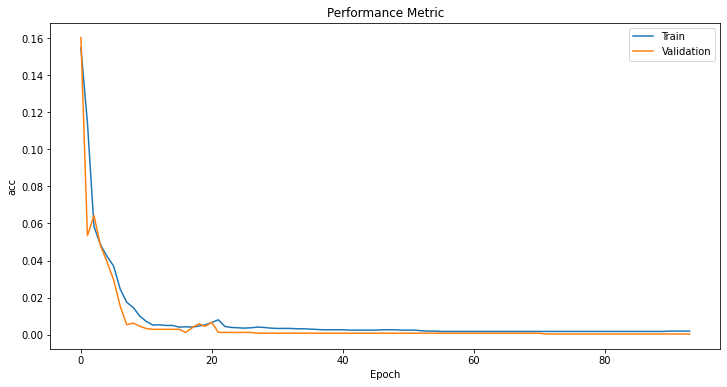

In [40]:
## 4) 모델 훈련
fl = ForecastLSTM()
fl.fit_lstm(
    df=df_train,
    steps=steps,
    single_output=single_output,
    metrics=metrics,
    **lstm_params,
)

In [41]:
## 5) Validation dataset 예측 성능
df_fcst_val = fl.forecast_validation_dataset()

1/1 [==============================] - 0s 28ms/step


In [42]:
val_loss = calculate_metrics(df_fcst=df_fcst_val)[metrics]
print(f"{metrics} of validation dataset: {val_loss.round(3)}")

acc of validation dataset: 82.701


In [43]:
proposed = val_loss

### 3. 인증 및 대응

In [44]:
import pandas as pd
import random 

In [45]:
# CSV file 불러오기
df1 =  pd.read_csv("/content/drive/MyDrive/Dataset/(block) ton_memory.csv")

In [46]:
# 학습한 모델 불러오기
# from keras.models import load_model

# # model.save('pretrained_model.h5')  # 모델을 컴퓨터에 저장
# model = load_model('pretrained_model.h5') # 모델을 새로 불러옴
# -> 이 부분을 해보려고 했는데, 우리가 사용한 코드가 Keras에서 제공하고 있는 기본 코드가 아니라 모델 저장이 안됩니다.. 그냥 코드 안에 포함시켜서 써야할 것 같아요..

In [47]:
# if df1.loc[1][12] == 'normal':
#   print('true')

In [48]:
# User ID 재분배

# 공격자끼리 동일한 User ID Set 설정하고 정상 사용자끼리 동일한 User ID Set 설정
# 공격자가 3개의 User ID(1-3)를 가진다고 가정하고, 정상 사용자는 10개의 User ID(10-19)를 가진다고 가정하였음


random_list = list()
for i in range(0, len(df1)):
    if df1.loc[i][12] == 'normal':
      value1 = random.randrange(10, 20)
      random_list.append(value1)
    elif df1.loc[i][12] ==  'dos':
      value2 = random.randrange(1, 4)
      random_list.append(value2)

col = ['User']
df2 = pd.DataFrame(random_list, columns=col)

# 최종 데이터프레임
df = pd.concat([df1, df2], axis=1)

# df.to_csv("C://Users/user/Desktop/(block) ton_memory_user_v3.csv") #저장하려면 이거 사용

In [49]:
# User ID 추가하기 전
df1

,ts,PID,MINFLT,MAJFLT,VSTEXT,VSIZE,RSIZE,VGROW,RGROW,MEM,CMD,label,type
0,1554218915,3257,859502,54,193,2.0,519.1,2.0,519.1,0.14,Web-Content,0,normal
1,1554218920,3197,247354,95,193,2.6,402.0,2.6,402.0,0.11,firefox,0,normal
2,1554218925,1442,57311,33,2219,764.2,290.7,764.2,290.7,0.08,Xorg,0,normal
3,1554218930,3119,68006,17,3063,725.9,116.8,725.9,116.8,0.03,update-manager,0,normal
4,1554218935,2797,72300,69,1350,1.4,109.6,1.4,109.6,0.03,nautilus,0,normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,1556219648,3293,1912,0,148,17624.0,2372.0,0.0,0.0,0.00,atop,1,dos
9996,1556219653,2499,0,0,415,40184.0,2288.0,0.0,0.0,0.00,dbus-daemon,1,dos
9997,1556219658,1401,3,0,36,19296.0,824.0,0.0,0.0,0.00,irqbalance,1,dos
9998,1556219663,2576,0,0,121,22308.0,640.0,0.0,0.0,0.00,upstart-dbus-b,1,dos


In [50]:
# User ID 추가한 후
df

,ts,PID,MINFLT,MAJFLT,VSTEXT,VSIZE,RSIZE,VGROW,RGROW,MEM,CMD,label,type,User
0,1554218915,3257,859502,54,193,2.0,519.1,2.0,519.1,0.14,Web-Content,0,normal,11
1,1554218920,3197,247354,95,193,2.6,402.0,2.6,402.0,0.11,firefox,0,normal,13
2,1554218925,1442,57311,33,2219,764.2,290.7,764.2,290.7,0.08,Xorg,0,normal,17
3,1554218930,3119,68006,17,3063,725.9,116.8,725.9,116.8,0.03,update-manager,0,normal,14
4,1554218935,2797,72300,69,1350,1.4,109.6,1.4,109.6,0.03,nautilus,0,normal,14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,1556219648,3293,1912,0,148,17624.0,2372.0,0.0,0.0,0.00,atop,1,dos,1
9996,1556219653,2499,0,0,415,40184.0,2288.0,0.0,0.0,0.00,dbus-daemon,1,dos,3
9997,1556219658,1401,3,0,36,19296.0,824.0,0.0,0.0,0.00,irqbalance,1,dos,3
9998,1556219663,2576,0,0,121,22308.0,640.0,0.0,0.0,0.00,upstart-dbus-b,1,dos,1


In [51]:
nput_data = df.sample(n=3, replace=True)
print(nput_data)

              ts    PID  MINFLT  MAJFLT  VSTEXT    VSIZE   RSIZE  VGROW  \
8915  1554243490   1935       0       0     596    184.2  7284.0    0.0   
1318  1556138043  52887    2340       0     148  17884.0  2596.0    4.0   
7221  1556210438   2731       0       0      35    280.1  5144.0    0.0   

      RGROW  MEM             CMD  label    type  User  
8915    0.0  0.0         apache2      0  normal    12  
1318    0.0  0.0            atop      1     dos     1  
7221    0.0  0.0  indicator-appl      1     dos     1  


In [52]:
# nput_data['User'][2431]

In [53]:
nput_data['User'].index[0]

8915

In [54]:
# nput_data['User'][6170]

In [55]:
# nput_data[:]['User']

<평가지표>
*   정확도: 탐지 정확도 측정(LSTM 모델)
*   스루풋: 네트워크 상의 어떤 노드나 터미널로 부터 또 다른 터미널로 전달되는 단위 시간(time unit)당 처리된 데이터량 (최대 10까지 처리할 수 있다고 가정했기 떄문에 최대 값은 10)

*   메모리 사용량: 사용한 메모리 / 전체 가용 메모리 (퍼센트 단위로 나타냄)

In [56]:
# 인증
iteration = 100
memory_list = list() # 결과 취합
throughput_list = list() # 스루풋 결과 취합 

for iter in range(iteration):
  
  # 메모리 버퍼 구현
  buffer_max = 5 # 최대 가용 메모리
  buffer_state = 0 # 현재 버퍼 상태
  buffer_state_2 = 0 # 업데이트된 버퍼 상태 
  time_unit = 10 #
  remain = list() # 패킷 점유 시간
  user_table = list()
  add = 0
  memory_usage = 0 # 현재 메모리 사용량
  throughput = 0 # 현재 스루풋

  # 특정 time unit이 있다고 할 때 10개
  for timeunit in range(0, time_unit):
    # 동시에 추출할 패킷 개수 선정
    packet_num = random.randrange(1, 6)
    print("동시 추출할 패킷 개수", packet_num)
    input_data = df.sample(n=packet_num, replace=True) # 한 행 추출(비복원)
    
    for k in range(0, packet_num): 
      # 공격자일 경우
      a = input_data['User'][input_data['User'].index[k]]
      if int(a) < 4:
      # 3 time unit 동안 점유
        buffer_state += 1
        remain.append(3)
        user_table.append(input_data['User'][input_data['User'].index[k]]) # user table에 user ID 업데이트
        
      # 정상 사용자일 경우 1 time unit 동안 점유
      else:
        buffer_state += 1
        remain.append(1)
        user_table.append(input_data['User'][input_data['User'].index[k]]) # user table에 user ID 업데이트
      
    print('처리 전 memory buffer 상태', buffer_state+add)
    print('패킷 처리 현황', remain)

    memory_usage = (buffer_state+add) / buffer_max #처리 전 메모리 버퍼 상태 반영
    # memory_usage = (len(remain) - (buffer_state)) / buffer_max 
    if memory_usage > 1:
      memory_usage = 1
    print('메모리 사용률: ', memory_usage * 100)
    memory_list.append(memory_usage * 100)
      
    # 다음 time unit 전까지 패킷 처리
    if buffer_state <= buffer_max: # 버퍼 사이즈보다 작다면
      for j in range(0, len(remain)):
        remain[j] = remain[j] - 1 # 1 time unit 동안 1만큼 처리
      # for j in range(0, len(remain)):
      #   buffer_state_2 += remain[j] # 업데이트된 버퍼 상태 확인
        
    else: # 버퍼 사이즈보다 크다면 처리할 수 있는 만큼만 처리
      # 처리 가능한 양 정의
      enable = buffer_state - buffer_max  
      if enable >= len(remain):
        enable = len(remain)
      for j in range(0, enable):
        remain[j] = remain[j] - 1 # 1 time unit 동안 1만큼 처리 (먼저 들어온 데이터 우선 처리)
      # for j in range(0, len(remain)):
      #   buffer_state_2 += remain[j] # 업데이트된 버퍼 상태 확인
      buffer_state_2 = len(remain)
      
    # print('처리 후 memory buffer 상태', buffer_state_2)

    # 버퍼에 0 값 삭제 (0인건 이미 처리가 완료되었기 때문에 추가적으로 처리할 필요없음)
    for check in range(0, len(remain)):
      if remain[check] == 0:
        throughput += 1
    while 0 in remain:    
      remain.remove(0)
    buffer_state =  buffer_state_2
    # buffer_state_2 = 0 # 버퍼 상태 초기화 (이 변수는 어차피 재측정되기 때문에 초기화하지 않으면 계속 누적됨. 초기화 필요)
    user_table = list(set(user_table))
    print('남은 패킷', remain)
    add = len(remain)
    print('Throughput', throughput)
    throughput_list.append(throughput)
    throughput = 0
    print('인증 테이블', user_table)
    print()

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
동시 추출할 패킷 개수 4
처리 전 memory buffer 상태 7
패킷 처리 현황 [2, 2, 2, 1, 1, 3, 1]
메모리 사용률:  100
남은 패킷 [1, 1, 1, 2]
Throughput 3
인증 테이블 [1, 2, 11, 13, 14, 15, 16, 18, 19]

동시 추출할 패킷 개수 3
처리 전 memory buffer 상태 7
패킷 처리 현황 [1, 1, 1, 2, 3, 1, 1]
메모리 사용률:  100
남은 패킷 [1, 2]
Throughput 5
인증 테이블 [1, 2, 11, 13, 14, 15, 16, 17, 18, 19]

동시 추출할 패킷 개수 4
처리 전 memory buffer 상태 6
패킷 처리 현황 [1, 2, 3, 3, 3, 1]
메모리 사용률:  100
남은 패킷 [1, 2, 2, 2]
Throughput 2
인증 테이블 [1, 2, 3, 11, 13, 14, 15, 16, 17, 18, 19]

동시 추출할 패킷 개수 5
처리 전 memory buffer 상태 9
패킷 처리 현황 [1, 2, 2, 2, 3, 3, 1, 3, 1]
메모리 사용률:  100
남은 패킷 [1, 1, 1, 2, 2, 2]
Throughput 3
인증 테이블 [1, 2, 3, 10, 11, 13, 14, 15, 16, 17, 18, 19]

동시 추출할 패킷 개수 3
처리 전 memory buffer 상태 9
패킷 처리 현황 [1, 1, 1, 2, 2, 2, 3, 3, 1]
메모리 사용률:  100
남은 패킷 [1, 1, 1, 2, 2]
Throughput 4
인증 테이블 [1, 2, 3, 10, 11, 13, 14, 15, 16, 17, 18, 19]

동시 추출할 패킷 개수 4
처리 전 memory buffer 상태 4
패킷 처리 현황 [3, 1, 1, 1]
메모리 사용률:  80.0
남은 패킷 [2]
Throughput 3
인증 테이블 [11, 19, 3, 15]

동

In [57]:
# 결과 정리

throughput_list2 = [0,0,0,0,0,0,0,0,0,0]
memory_list2 = [0,0,0,0,0,0,0,0,0,0]

for i in range(0, len(throughput_list), 10):
  for k in range(0, 10):
    throughput_list2[k] += throughput_list[i+k]

for i in range(0, 10):
  throughput_list2[i] = throughput_list2[i] / iteration

for i in range(0, len(memory_list), 10):
  for k in range(0, 10):
    memory_list2[k] += memory_list[i+k]
  
for i in range(0, 10):
  memory_list2[i] = memory_list2[i] / iteration


print(throughput_list2)
print(memory_list2)

[1.5, 1.32, 3.05, 3.15, 2.9, 3.09, 2.96, 2.81, 3.04, 3.3]
[60.4, 76.6, 89.2, 91.4, 91.4, 89.8, 91.4, 91.8, 93.2, 93.0]


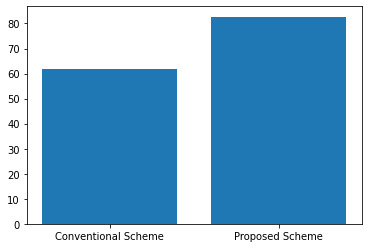

In [58]:
# 탐지율 시각화
import matplotlib.pyplot as plt
import numpy as np

x = np.arange(2)
models = ['Conventional Scheme', 'Proposed Scheme']
values = [conventional, proposed]

plt.bar(x, values)
plt.xticks(x, models)

plt.show()

In [59]:
print(conventional)

61.958333333333336


In [60]:
print(proposed)

82.70146137787057


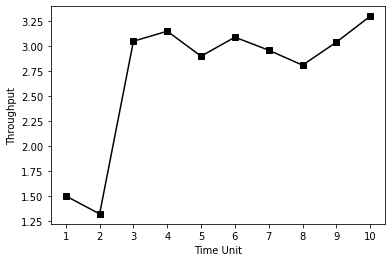

In [61]:
# 시각화 (평가지표 확인용, 사실상 이게 종래모델 결과임)



x_value = [1,2,3,4,5,6,7,8,9,10] #time unit에 따른 실험 결과 측정

plt.rcParams['font.family'] = 'Times New Roman'
plt.plot(x_value, throughput_list2, marker='s', color='black')

plt.xlabel('Time Unit')
plt.ylabel('Throughput')
plt.xticks([1,2,3,4,5,6,7,8,9,10])
plt.show()


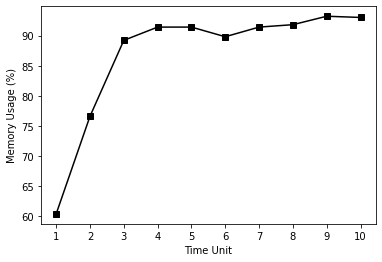

In [62]:
plt.rcParams['font.family'] = 'Times New Roman'
plt.plot(x_value, memory_list2, marker='s', color='black')

plt.xlabel('Time Unit')
plt.ylabel('Memory Usage (%)')
plt.xticks([1,2,3,4,5,6,7,8,9,10])
plt.show()
